# TestingEvaluateClass

# Libraries

In [1]:
# directory set up 
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

# data attainment
import pandas as pd

# mathematical
import tensorflow as tf
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from Extra_Work.PythonFiles.preprocessing import scale_data

# modelling
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dense

# evaluation
from Extra_Work.PythonFiles.modelling import evaluate_models
from Extra_Work.PythonFiles.modelling import FeedForward

# plotting
import matplotlib.pyplot as plt

# setting global seeds
tf.random.set_seed(1)
np.random.seed(1)

# Data

In [2]:
# load data

df = pd.read_csv('../Data/dataset2.csv')

X, scalers = scale_data(df[df.columns[:-1]], mode = 'standard')
#X['Spring constant (N per m)'] = 0
#X['Ball radius (mm)'] = 0

y = df[df.columns[-1]]

y_binary = to_categorical(y)

data = train_test_split(
    X,y_binary, test_size = 0.8, random_state = 23
)



In [3]:
X.head(1)

,Arm length (m),Ball weight (kg),Ball radius (mm),Air temperature (deg C),Spring constant (N per m),Device weight (kg)
0,0.109767,0.061983,-0.732493,0.007335,-0.128493,0.774432


# Data Exploration

# Model Cell

In [7]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.activations import elu, relu 
from tensorflow.keras.layers import Activation
# add automation to this
def uncompiled_model():
    inputs = Input(shape=(6,), name='Data')
    x = Dense(8, activation = 'relu')(inputs)
    x = Dense(8, activation='relu')(x)

    #x = Dense(4, activation='linear')(x)
    outputs = Dense(2, activation='tanh', name='TargetHit')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def compile_model():
    model = uncompiled_model()
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy",
                 "binary_accuracy",
                 "binary_crossentropy",
                 "categorical_accuracy"
                 ],
    )
    return model

def compiler(model):
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy",
             "binary_accuracy",
             "binary_crossentropy",
             "categorical_accuracy"
             ],
    )
    return model
    

# Test Model

In [8]:
feedforward = FeedForward()


In [10]:
model = compile_model()
instance = evaluate_models(
    uncompiled_model(), compiler, *data
)

scores, histories = instance.cross_validate(epochs = 100, verbose = 0)


25/25 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.7163 - binary_accuracy: 0.7212 - binary_crossentropy: 0.6014 - categorical_accuracy: 0.7163
average loss:  0.6536670923233032
average accuracy:  0.6642500042915345


[0.62       0.64375001 0.66250002 0.67874998 0.71625   ]


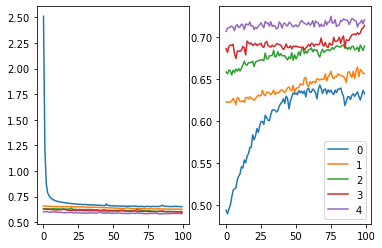

In [11]:
instance.plot_histories(histories)
print(np.asarray(scores)[:,1])

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes = axes.reshape(1,2)
axes[0,1]

In [ ]:
instance.evaluate(epochs = 100, verbose = 0)


In [ ]:
feedforward.print_params(-3)

In [ ]:
#feedforward.plot_model()

In [ ]:
#model = feedforward.get_model()
#yhat = model.predict(X_test)
#yhat = yhat[:,1]
#yhat[yhat > 0.5] = 1
#yhat[yhat <=0.5] = 0

In [ ]:
#(yhat == y_test[:,1]).sum()/len(yhat)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,8))
plt.show()

In [ ]:
def function(*args, K = 5,**kwargs):
    print(args) if not args else print(args[0])
    print(kwargs)
    fig, ax = plt.subplots(**kwargs)
    plt.show()
    
function(2,figsize = (8,8))

https://dbader.org/blog/meaning-of-underscores-in-python

https://keras.io/api/layers/initializers/

https://stats.stackexchange.com/questions/330559/why-is-tanh-almost-always-better-than-sigmoid-as-an-activation-function

https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

https://ruder.io/optimizing-gradient-descent/

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html
